前準備

In [194]:
#numpy, matplotlib, pandasのインポート
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import unicodedata

#日付データの変更のためインポート
import datetime as dt

#lightGBMのインポート
import lightgbm as lgb

#訓練データとテストデータ分割のためにインポート
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

#標準化のためインポート
from sklearn.preprocessing import StandardScaler

#エンコーディングのためインポート
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#精度検証のためインポート
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

#ハイパーパラメータチューニングのためにインポート
from sklearn.model_selection import GridSearchCV

#特徴量選択のためにインポート
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

#ロジスティック回帰のためにインポート
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

#SVMのためにインポート
from sklearn import svm

#決定木のためにインポート
from sklearn.tree import DecisionTreeClassifier, export_graphviz

#ランダムフォレストのためにインポート
from sklearn.ensemble import RandomForestClassifier

#アダブーストのためにインポート
from sklearn.ensemble import AdaBoostClassifier

#CatBoostのためにインポート
from catboost import CatBoostClassifier
from catboost import Pool

# SMOTEのためにインポート
# from imblearn.over_sampling import SMOTE

In [195]:
import warnings
warnings.filterwarnings('ignore')

In [196]:
# notebookの設定

# データフレームの最大表示行数、列数を広げる
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

# 図のサイズ
plt.rcParams["figure.figsize"]=(8,4)

# matplotlibのフォント
font = 'Yu Mincho'

In [197]:
#学習データ、テストデータの読み込み
train0 = pd.read_csv('dataset/train.csv')
test0 = pd.read_csv('dataset/test.csv')

In [230]:
train0

'結婚済み、乗用車なし、子供なし'

In [199]:
test0

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,customer_info
0,3489,４８歳,Self Enquiry,2,13分,Small Business,Male,1.0,4.0,Super De|uxe,3.0,7,0,3,AVP,496950.0,結婚済み 車所持 子供なし
1,3490,30代,Self Enquiry,2,12分,Small Business,Ｆｅｍａｌｅ,1.0,4.0,Standard,3.0,4,1,3,Senior Manager,月収30.0万円,結婚済み、車未所持、子供なし
2,3491,25歳,Self Enquiry,1,540秒,Salaried,Female,1.0,4.0,Basic,3.0,1,0,3,Executive,月収26.0万円,離婚済み、自動車未所有、子供なし
3,3492,21歳,Company Invited,2,420秒,Salaried,Male,1.0,4.0,Basic,4.0,1,0,3,Senior Manager,259875.0,離婚済み、自動車所有、子供なし
4,3493,41歳,Company Invited,1,7分,Salaried,MALE,1.0,4.0,Basic,3.0,1,0,4,Executive,268830.0,独身/車所持／子供なし
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3484,6973,41歳,Company Invited,1,14分,Small Business,Female,1.0,3.0,Basic,3.0,2,0,4,Executive,261840.0,結婚済み/車なし／子供無し
3485,6974,44歳,Company Invited,1,35分,Salaried,Male,3.0,5.0,Deluxe,3.0,3,0,3,Manager,349770.0,結婚済み、自家用車あり、子供1人
3486,6975,24歳,Self Enquiry,2,21分,Small Business,male,2.0,3.0,basic,3.0,2,0,3,Executive,月収27.0万円,独身、車未所持、子供なし
3487,6976,25歳,Self Enquiry,1,9分,Small Business,MALE,2.0,3.0,Basic,3.0,2,0,3,Executive,272430.0,結婚済み、車未所持、こども1人


In [200]:
# 不要な変数の削除

# 変数名と列番号の対応を表示
col = pd.DataFrame(train0.columns.values).T

# dropの実行,事故率に関係ないデータは予測に利用できないのでdrop(後々他の変数をdropしたくなった時楽な様に列番号でdropする)
train1 = train0.drop(train0.columns[0],axis=1) 
test1 = test0.drop(test0.columns[0],axis=1)

In [201]:
train1

,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,customer_info,ProdTaken
0,50歳,Self Enquiry,2,900秒,Large Business,male,1.0,4.0,Basic,3.0,5,1,4,Executive,253905.0,未婚 車未所持 子供なし,1
1,56歳,Company Invited,1,14分,Salaried,Male,1.0,4.0,Standard,3.0,2,1,4,Senior Manager,404475.0,"離婚済み,車あり,子供無し",0
2,NaN,Self Enquiry,1,10分,Large Business,Female,1.0,3.0,Basic,3.0,4,0,4,Executive,278145.0,"結婚済み、自動車未所有,子供なし",1
3,三十七歳,Self Enquiry,2,1080秒,Small Business,female,1.0,3.0,Standard,4.0,1,0,5,Senior Manager,326805.0,離婚済み、車所持、子供無し,0
4,48歳,Company Invited,3,1020秒,Small Business,female,1.0,3.0,Basic,4.0,4,0,4,Executive,258435.0,独身／車所持／無子,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3484,40歳,Self Enquiry,2,1560秒,Salaried,Male,2.0,3.0,Basic,3.0,3,0,1,Executive,258900.0,離婚済み 乗用車所持 子供なし,1
3485,40代,Self Enquiry,1,9分,Large Business,Male,3.0,3.0,Basic,5.0,5,0,3,Executive,260415.0,結婚済み、車所持、子供2人,0
3486,31歳,Self Enquiry,1,840秒,Small Business,FEMALE,3.0,2.0,Standard,3.0,5,0,4,Senior Manager,317340.0,独身／車所持／こども1人,0
3487,56歳,Company Invited,2,900秒,Salaried,Male,3.0,6.0,King,3.0,7,1,4,VP,527910.0,結婚済み、自動車未所有、子供2人,1


In [274]:
#目的変数を分離する

train_x = train1.drop(['ProdTaken'], axis=1)
train_y = train1['ProdTaken']
test_x = test1



In [237]:
# 変数名と列番号の対応を表示
col = pd.DataFrame(train1.columns.values).T
col

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,customer_info,ProdTaken


In [238]:
    # Age numeric
    # 漢数字とアラビア数字のマッピング
    kanji_to_num = {
        '一': 1, '二': 2, '三': 3, '四': 4, '五': 5, '六': 6, '七': 7, '八': 8, '九': 9,'十': 10, '百': 100, '千': 1000, '万': 10000,'零': 0, '〇': 0
    }

    def kanji_to_arabic(kanji):
        result = 0
        temp = 0
        for char in kanji:
            value = kanji_to_num.get(char, None)
            if value is not None:
                if value < 10:
                    if temp == 0:
                        temp = value
                    else:
                        temp = temp * 10 + value
                elif value >= 10:
                    if temp == 0:
                        temp = 1
                    result += temp * value
                    temp = 0
        return result + temp

    def process_age(age):
        if age is None or str(age) == 'nan':
            return None
        age = unicodedata.normalize('NFKC', age)
        age = ''.join([c for c in age if c.isdigit() or c in kanji_to_num])
        if age.isdigit():
            return int(age)
        return kanji_to_arabic(age)

    # 変換適用
    train_x['Age'] = train_x['Age'].apply(process_age)

In [239]:
    # TypeofContact categorical
    def TypeofContact_to_dummy(str):
        if str == 'Self Enquiry':
            return 1
        elif str == 'Company Invited':
            return 0

    train_x['TypeofContact'] = train_x['TypeofContact'].apply(TypeofContact_to_dummy)    

In [240]:
# CityTier 順序尺度
train_x['CityTier'].value_counts()

2    1596
1    1475
3     418
Name: CityTier, dtype: int64

In [241]:
# DurationOfPitch numeric
print(train_x['DurationOfPitch'].value_counts())
def convert_to_minutes(duration):
    # durationがfloat型またはNoneである可能性があるため、文字列であることを確認
    if pd.isnull(duration):
        return None  # NaNの場合、Noneを返す
    duration = str(duration)  # 文字列に変換してエラーを防ぐ
    if '分' in duration:
        return float(duration.replace('分', ''))
    elif '秒' in duration:
        return float(duration.replace('秒', '')) / 60  # 秒を分に変換し、整数で返す

# この修正された関数をデータフレームに適用
train_x['DurationOfPitch'] = train_x['DurationOfPitch'].apply(convert_to_minutes)

print(train_x['DurationOfPitch'].value_counts())

8分       259
9分       237
15分      216
14分      207
16分      202
10分      181
7分       170
13分      150
11分      113
12分      111
17分      100
540秒      90
480秒      79
420秒      69
6分        69
900秒      68
840秒      59
960秒      57
18分       56
780秒      53
600秒      50
660秒      47
720秒      47
32分       42
23分       37
1020秒     36
22分       34
24分       32
31分       31
25分       28
20分       28
27分       25
21分       24
33分       23
30分       22
26分       21
34分       21
1080秒     18
28分       18
19分       17
35分       17
1380秒     14
29分       12
1860秒     12
5分        12
1320秒     11
360秒      11
1920秒     11
1980秒     11
1680秒     11
1620秒     10
1500秒     10
1800秒      9
1740秒      8
1440秒      8
2100秒      8
2040秒      8
1200秒      8
1260秒      7
1560秒      6
300秒       6
2160秒      4
36分        3
4分         2
1140秒      2
Name: DurationOfPitch, dtype: int64
8.0     338
9.0     327
15.0    284
14.0    266
16.0    259
7.0     239
10.0    231
13.0    203
11.0    160
12.0    158

In [242]:
# Occupation categorical
print(train_x['Occupation'].value_counts())
def Occupation_to_dummy(str):
    if str == 'Large Business':
        return 2
    elif str == 'Small Business':
        return 1
    elif str == 'Salaried':
        return 0
    
train_x['Occupation'] = train_x['Occupation'].apply(Occupation_to_dummy)
print(train_x['Occupation'].value_counts())

Small Business    1727
Salaried          1401
Large Business     361
Name: Occupation, dtype: int64
1    1727
0    1401
2     361
Name: Occupation, dtype: int64


In [243]:
# Gender categorical
print(train_x['Gender'].value_counts())
def Gender_dealing(gender):
    # 文字列を半角に変換し、大文字に統一
    gender = unicodedata.normalize('NFKC', gender).upper().strip()
    # 不要な空白を削除
    gender = ''.join(gender.split())
    
    if 'FEMALE' in gender:
        return 1
    elif 'MALE' in gender:
        return 0
    else:
        return None  # 性別が識別できない場合はNoneを返す

train_x['Gender'] = train_x['Gender'].apply(Gender_dealing)
print(train_x['Gender'].value_counts())

Male       1226
Female      739
male        468
female      266
MALE        183
Ｍａｌｅ        126
Fe Male     109
FEMALE       99
Ｆｅｍａｌｅ       89
ｍａｌｅ         43
ｆｅｍａｌｅ       36
fe male      29
FE MALE      23
ＭＡＬＥ         18
Ｆｅ　Ｍａｌｅ      15
ＦＥＭＡＬＥ       13
ｆｅ　ｍａｌｅ       6
ＦＥ　ＭＡＬＥ       1
Name: Gender, dtype: int64
0    2064
1    1425
Name: Gender, dtype: int64


In [244]:
# NumberOfPersonVisiting numeric
print(train_x['NumberOfPersonVisiting'].value_counts())

2.0    1608
3.0    1377
1.0     336
4.0     168
Name: NumberOfPersonVisiting, dtype: int64


In [245]:
# NumberOfFollowups numeric
print(train_x['NumberOfFollowups'].value_counts())
def NumberOfFollowups_dealing(int):
    if int >= 100:
        return int /100
    else:
        return int

train_x['NumberOfFollowups'] = train_x['NumberOfFollowups'].apply(NumberOfFollowups_dealing)
print(train_x['NumberOfFollowups'].value_counts())

4.0      1396
3.0      1279
5.0       519
2.0       108
1.0        77
6.0        38
300.0      17
400.0      15
500.0       5
100.0       1
600.0       1
Name: NumberOfFollowups, dtype: int64
4.0    1411
3.0    1296
5.0     524
2.0     108
1.0      78
6.0      39
Name: NumberOfFollowups, dtype: int64


In [246]:
# ProductPitched categorical
print(train_x['ProductPitched'].value_counts())
def standardize_product(product):
    # 文字列を半角に変換し、小文字に統一
    product = unicodedata.normalize('NFKC', product).lower().strip()
    # 不要な空白や特殊記号を削除
    product = ''.join(product.split())
    product = product.replace('|', 'l').replace('×', 'x').replace('𝘤', 'c').replace('𝖺', 'a').replace('𝙳', 'd')
    # その他特殊文字を通常の英字に置換
    product = product.replace('ᗞ', 'd').replace('𐊡', 'a').replace('𝘳', 'r').replace('ꓢ', 's').replace('ı', 'i')
    product = product.replace('β', 'b').replace('в', 'b').replace('с', 'c').replace('տ', 's').replace('ς', 'c')
    product = product.replace('ꭰ', 'd').replace('ε', 'e').replace('ι', 'i').replace('α', 'a').replace('ո', 'n')
    product = product.replace('ѕ', 's')
    product = product.replace('aasic', 'basic')
    return product

train_x['ProductPitched'] = train_x['ProductPitched'].apply(standardize_product)
print(train_x['ProductPitched'].value_counts())

Basic           887
Deluxe          836
Standard        648
Super Deluxe    238
basic           106
BASIC           104
DELUXE           93
King             91
deluxe           88
standard         86
STANDARD         80
super deluxe     35
SUPER DELUXE     27
KING             18
Basıc            15
king             14
De|uxe           12
Βasic             9
Basi𝘤             5
Delu×e            5
Super De|uxe      4
Вasic             4
Super ᗞeluxe      4
𐊡asic             4
Stand𝖺rd          3
Տtandard          3
ᗞeluxe            3
Staոdard          3
Basiс             3
Standa𝘳d          3
Basiϲ             3
S𝘵andard          3
Standar𝔡          2
Super Ꭰeluxe      2
ꓢuper Deluxe      2
Ѕuper Deluxe      2
𝙳eluxe            2
B𝖺sic             2
St𝖺ndard          2
ꓢtandard          2
DELUXΕ            1
staոdard          1
Ѕtandard          1
𐊡asi𝘤             1
Basıϲ             1
Ꭰeluxe            1
Kıոg              1
Super 𝙳eluxe      1
Kiոg              1
Βasıc             1


In [247]:
# PreferredPropertyStar 順序尺度
print(train_x['PreferredPropertyStar'].value_counts())

3.0    2147
4.0    1145
5.0     197
Name: PreferredPropertyStar, dtype: int64


In [248]:
# NumberOfTrips numeric
print(train_x['NumberOfTrips'].value_counts())
def NumberOfTrips_dealing(str):
    if pd.isnull(str):
        return None 
    if '半年に' in str:
        return 2 * int(str.replace('半年に', '').replace('回', ''))
    elif '年に' in str:
        return int(str.replace('年に', '').replace('回', ''))
    elif '四半期に' in str:
        return 4 * int(str.replace('四半期に', '').replace('回', ''))
    else :
        return int(str)

train_x['NumberOfTrips'] = train_x['NumberOfTrips'].apply(NumberOfTrips_dealing)
print(train_x['NumberOfTrips'].value_counts())

2         1006
3          699
5          436
1          349
7          219
年に2回       141
4          141
年に3回       121
6          109
年に5回        79
年に1回        60
年に7回        37
年に6回        21
年に4回        19
半年に1回       17
8            8
四半期に1回       3
年に8回         2
Name: NumberOfTrips, dtype: int64
2.0    1164
3.0     820
5.0     515
1.0     409
7.0     256
4.0     163
6.0     130
8.0      10
Name: NumberOfTrips, dtype: int64


In [249]:
# Passport categorical(dummy)
print(train_x['Passport'].value_counts())

0    3131
1     358
Name: Passport, dtype: int64


特徴量に関する処理

In [250]:
# PitchSatisfactionScore 順序尺度だけど間隔尺度的要素あり
print(train_x['PitchSatisfactionScore'].value_counts())

2    1269
4     739
3     692
1     686
5     103
Name: PitchSatisfactionScore, dtype: int64


In [251]:
# Designation categorical
print(train_x['Designation'].value_counts())
def standardize_product(product):
    # 文字列を半角に変換し、小文字に統一
    product = unicodedata.normalize('NFKC', product).lower().strip()
    # 不要な空白や特殊記号を削除
    product = ''.join(product.split())
    product = product.replace('|', 'l').replace('×', 'x').replace('𝘤', 'c').replace('𝖺', 'a').replace('𝙳', 'd')
    # その他特殊文字を通常の英字に置換
    product = product.replace('ᗞ', 'd').replace('𐊡', 'a').replace('𝘳', 'r').replace('ꓢ', 's').replace('ı', 'i')
    product = product.replace('β', 'b').replace('в', 'b').replace('с', 'c').replace('տ', 's').replace('ς', 'c')
    product = product.replace('ꭰ', 'd').replace('ε', 'e').replace('ι', 'i').replace('α', 'a').replace('ո', 'n')
    product = product.replace('ѕ', 's').replace('μ', 'm').replace('е', 'e').replace('а', 'a').replace('ѵ', 'v')
    product = product.replace('aasic', 'basic')
    return product

train_x['Designation'] = train_x['Designation'].apply(standardize_product)
print(train_x['Designation'].value_counts())

Executive         1090
Manager           1011
Senior Manager     825
AVP                299
VP                 117
Μanager             13
Exеcutive           10
Exеcutivе            9
Manαger              8
Managеr              8
Executivе            7
АVP                  7
Executiѵe            6
Senior Managеr       6
Execuｔive            5
Senior Manαger       4
Mαnager              4
ΑVP                  3
Exеcutiѵе            3
Manage𝙧              3
Еxecutive            3
Sеnior Manager       3
Senior Mαnαger       3
Exеcｕtive            2
Senior Manage𝙧       2
Տenior Manager       2
VＰ                   2
Е×еcutive            2
E×ecutive            2
Mαnage𝙧              2
AVＰ                  2
Executiѵе            2
Mαnαger              2
Ѕenior Manager       2
Еxecutivе            2
Sеnior Managеr       1
E×ecｕtive            1
Mαnagеr              1
Exеcｕtivе            1
Еxеcutivе            1
Senior Mαnager       1
Μanagеr              1
Manαgеr              1
Execｕtive  

In [252]:
# MonthlyIncome numeric
# print(train_x['MonthlyIncome'].value_counts())
value_list = train_x['MonthlyIncome'].tolist()
print(list(dict.fromkeys(value_list)))

def MonthlyIncome_dealing(str):
    if pd.isnull(str):
        return None 
    if '月収' in str:
        return 10000 * float(str.replace('月収', '').replace('万円', ''))
    elif '万円' in str:
        return 10000 * float(str.replace('万円', ''))
    else:
        return float(str)

train_x['MonthlyIncome'] = train_x['MonthlyIncome'].apply(MonthlyIncome_dealing)
# print(train_x['MonthlyIncome'].value_counts())
value_list = train_x['MonthlyIncome'].tolist()
print(sorted(list(dict.fromkeys(value_list))))

['253905.0', '404475.0', '278145.0', '326805.0', '258435.0', '月収26.0万円', '453180.0', '261900.0', '247800.0', '257610.0', '351900.0', '416430.0', '477555.0', '月収44.0万円', '月収30.0万円', '253665.0', '258600.0', '月収50.0万円', '月収40.0万円', '286245.0', '455250.0', '263715.0', '262725.0', '431265.0', '250275.0', '303345.0', '256845.0', '368940.0', '456405.0', '258885.0', '316680.0', '359730.0', '月収41.0万円', '月収27.0万円', '255405.0', '485055.0', '月収37.0万円', '401775.0', '477000.0', '378210.0', '248490.0', '268440.0', '362580.0', '282075.0', '356760.0', '364980.0', '350310.0', '429570.0', '272475.0', '273840.0', '372150.0', '462615.0', '345690.0', '397245.0', '297855.0', '269895.0', '427050.0', '418080.0', '264615.0', '415545.0', '258915.0', '507870.0', '303960.0', '309645.0', '479610.0', '463050.0', '270735.0', '263865.0', '316770.0', '358935.0', '263010.0', '273900.0', '257295.0', '438195.0', '267480.0', '438210.0', '371820.0', '393705.0', '263730.0', '366900.0', '262560.0', '437895.0', '269235.0', '42

In [253]:
# customer_info
# print(train_x['customer_info'].value_counts())
value_list = train_x['customer_info'].tolist()
print(list(dict.fromkeys(value_list)))

['未婚 車未所持 子供なし', '離婚済み,車あり,子供無し', '結婚済み、自動車未所有,子供なし', '離婚済み、車所持、子供無し', '独身／車所持／無子', '独身、車未所持、子供ゼロ', '独身 自家用車あり 子供なし', '結婚済み、車未所持、子供なし', '独身/車未所持/子供無し', '結婚済み、車所持、非育児家庭', '未婚,車保有、子供なし', '離婚済み/車あり/子供なし', '独身 車所持 子供なし', '独身\u3000車未所持\u3000子供なし', '未婚、車所持、子供無し', '結婚済み、自動車未所有、子供無し', '結婚済み\t自動車未所有\t子供なし', '未婚/車保有なし/子供なし', '離婚済み、乗用車所持、子供なし', '離婚済み 自動車未所有\u3000子供なし', '結婚済み、車あり、子供無し', '離婚済み、車所持、子供なし', '結婚済み、乗用車なし、子供なし', '未婚、自動車所有、子供なし', '結婚済み\u3000自家用車あり\u3000子供なし', '独身,車未所持,子供なし', '結婚済み 車未所持 子供無し', '離婚済み,自動車所有,子供なし', '未婚、車所持、子供なし', '結婚済み\n自動車未所有\n子供なし', '独身／車未所持／子供なし', '独身 車保有 子供無し', '独身、車所持、子供ゼロ', '結婚済み、車所持、無子', '独身/自家用車あり/子供無し', '結婚済み\u3000車未所持\u3000子供なし', '独身、車未所持、子供なし', '結婚済み/車未所持/子供なし', '結婚済み、車所持、子供なし', '結婚済み、自動車未所有、子供なし', '結婚済み、自動車所有、子供無し', '未婚,自家用車なし,子供なし', '離婚済み／自家用車なし/子供なし', '離婚済み 車未所持 子供ゼロ', '未婚 車保有 子供なし', '結婚済み\u3000車所持\u3000子供なし', '未婚、車未所持、子供無し', '未婚 車保有なし 子供ゼロ', '結婚済み/車所持/子供なし', '独身 車所持 子供無し', '独身、車未所持,子供無し', '独身、車保有なし、非育児家庭', '独身,自動車所有,子供なし', '離婚済み、自動車未所有、子供なし', '結婚済み\u3000車なし\u30

In [254]:
# customer_info
# print(train_x['customer_info'].value_counts())
value_list = train_x['customer_info'].tolist()
print(list(dict.fromkeys(value_list)))

def customer_info_dealing(str):
    # 文字列を半角に変換し、小文字に統一
    str = unicodedata.normalize('NFKC', str).lower().strip()
    # 不要な空白や特殊記号を削除
    str = str.replace('/', ' ').replace('／', ' ').replace('、', ' ').replace('　', ' ')
    str = str.replace('\u3000', ' ').replace('\t', ' ').replace('\n', ' ')
    str = re.sub(r'(?<=\S)\s+(?=\S)', ',', str, count=2)
    return str
    
train_x['customer_info'] = train_x['customer_info'].apply(customer_info_dealing)
train_x[['married', 'car_possesion', 'offspring']] = train_x_1['customer_info'].str.split(',', n=2, expand=True)



['未婚 車未所持 子供なし', '離婚済み,車あり,子供無し', '結婚済み、自動車未所有,子供なし', '離婚済み、車所持、子供無し', '独身／車所持／無子', '独身、車未所持、子供ゼロ', '独身 自家用車あり 子供なし', '結婚済み、車未所持、子供なし', '独身/車未所持/子供無し', '結婚済み、車所持、非育児家庭', '未婚,車保有、子供なし', '離婚済み/車あり/子供なし', '独身 車所持 子供なし', '独身\u3000車未所持\u3000子供なし', '未婚、車所持、子供無し', '結婚済み、自動車未所有、子供無し', '結婚済み\t自動車未所有\t子供なし', '未婚/車保有なし/子供なし', '離婚済み、乗用車所持、子供なし', '離婚済み 自動車未所有\u3000子供なし', '結婚済み、車あり、子供無し', '離婚済み、車所持、子供なし', '結婚済み、乗用車なし、子供なし', '未婚、自動車所有、子供なし', '結婚済み\u3000自家用車あり\u3000子供なし', '独身,車未所持,子供なし', '結婚済み 車未所持 子供無し', '離婚済み,自動車所有,子供なし', '未婚、車所持、子供なし', '結婚済み\n自動車未所有\n子供なし', '独身／車未所持／子供なし', '独身 車保有 子供無し', '独身、車所持、子供ゼロ', '結婚済み、車所持、無子', '独身/自家用車あり/子供無し', '結婚済み\u3000車未所持\u3000子供なし', '独身、車未所持、子供なし', '結婚済み/車未所持/子供なし', '結婚済み、車所持、子供なし', '結婚済み、自動車未所有、子供なし', '結婚済み、自動車所有、子供無し', '未婚,自家用車なし,子供なし', '離婚済み／自家用車なし/子供なし', '離婚済み 車未所持 子供ゼロ', '未婚 車保有 子供なし', '結婚済み\u3000車所持\u3000子供なし', '未婚、車未所持、子供無し', '未婚 車保有なし 子供ゼロ', '結婚済み/車所持/子供なし', '独身 車所持 子供無し', '独身、車未所持,子供無し', '独身、車保有なし、非育児家庭', '独身,自動車所有,子供なし', '離婚済み、自動車未所有、子供なし', '結婚済み\u3000車なし\u30

In [255]:
# married categorical
print(train_x['married'].value_counts())

結婚済み    1384
離婚済み     878
独身       646
未婚       581
Name: married, dtype: int64


In [256]:
# car_possesion categorival
print(train_x['car_possesion'].value_counts())

def car_possesion_dealing(str):
    if str in ['車未所持', '自動車未所有', '自家用車なし', '乗用車なし', '車なし', '車保有なし', 0]:
        return 0
    elif str in ['車所持', '自動車所有', '自家用車あり', '乗用車所持', '車保有', '車あり', 1]:
        return 1
    
train_x['car_possesion'] = train_x['car_possesion'].apply(car_possesion_dealing)

print(train_x['car_possesion'].value_counts())

車未所持      830
車所持       819
自動車未所有    437
自動車所有     392
自家用車なし    207
自家用車あり    188
乗用車なし     109
乗用車所持     107
車保有       104
車なし       104
車保有なし      98
車あり        94
Name: car_possesion, dtype: int64
0    1785
1    1704
Name: car_possesion, dtype: int64


In [257]:
830+819+437+392+207+188+109+107+104+104+98+94

3489

In [258]:
# offspring -1以外はnumeric
print(train_x['offspring'].value_counts())

def offspring_dealing(str):
    if '1' in str:
        return 1
    elif '2' in str:
        return 2
    elif '3' in str:
        return 3
    elif str in ['子供なし', '子供無し', '子供ゼロ', '非育児家庭', '無子']:
        return 0
    elif str in ['子供の数不明', '不明', 'わからない', '子育て状況不明', '子の数不詳']:
        return -1

train_x['offspring'] = train_x['offspring'].apply(offspring_dealing)
print(train_x['offspring'].value_counts())


子供1人        859
子供なし        539
子供2人        434
こども1人       410
子供無し        252
こども2人       229
1児          113
子供有り(1人)     94
子供有り 1人      84
子供ゼロ         75
非育児家庭        62
無子           57
子供有り 2人      55
2児           51
子供有り(2人)     49
子供3人         35
こども3人        20
子供の数不明       13
3児           10
子供有り,1人      10
不明           10
子供有り,2人       6
わからない         5
子育て状況不明       5
子の数不詳         4
子供有り 3人       3
子供有り(3人)      3
子供有り,3人       2
Name: offspring, dtype: int64
 1    1570
 0     985
 2     824
 3      73
-1      37
Name: offspring, dtype: int64


In [259]:
train_x.info()
train_x.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3489 entries, 0 to 3488
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     3389 non-null   float64
 1   TypeofContact           3483 non-null   float64
 2   CityTier                3489 non-null   int64  
 3   DurationOfPitch         3368 non-null   float64
 4   Occupation              3489 non-null   int64  
 5   Gender                  3489 non-null   int64  
 6   NumberOfPersonVisiting  3489 non-null   float64
 7   NumberOfFollowups       3456 non-null   float64
 8   ProductPitched          3489 non-null   object 
 9   PreferredPropertyStar   3489 non-null   float64
 10  NumberOfTrips           3467 non-null   float64
 11  Passport                3489 non-null   int64  
 12  PitchSatisfactionScore  3489 non-null   int64  
 13  Designation             3489 non-null   object 
 14  MonthlyIncome           3433 non-null   

Age                       100
TypeofContact               6
CityTier                    0
DurationOfPitch           121
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups          33
ProductPitched              0
PreferredPropertyStar       0
NumberOfTrips              22
Passport                    0
PitchSatisfactionScore      0
Designation                 0
MonthlyIncome              56
customer_info               0
married                     0
car_possesion               0
offspring                   0
dtype: int64

In [275]:
def preprocessing(train_x, train_y):
    # Age numeric
    # 漢数字とアラビア数字のマッピング
    kanji_to_num = {'一': 1, '二': 2, '三': 3, '四': 4, '五': 5, '六': 6, '七': 7, '八': 8, '九': 9,'十': 10, '百': 100, '千': 1000, '万': 10000,'零': 0, '〇': 0}
    def kanji_to_arabic(kanji):
        result = 0
        temp = 0
        for char in kanji:
            value = kanji_to_num.get(char, None)
            if value is not None:
                if value < 10:
                    if temp == 0:
                        temp = value
                    else:
                        temp = temp * 10 + value
                elif value >= 10:
                    if temp == 0:
                        temp = 1
                    result += temp * value
                    temp = 0
        return result + temp
    def process_age(age):
        if age is None or str(age) == 'nan':
            return None
        age = unicodedata.normalize('NFKC', age)
        age = ''.join([c for c in age if c.isdigit() or c in kanji_to_num])
        if age.isdigit():
            return int(age)
        return kanji_to_arabic(age)

    # TypeofContact categorical(dummy)
    def TypeofContact_to_dummy(str):
        if str == 'Self Enquiry':
            return 1
        elif str == 'Company Invited':
            return 0
        
    # CityTier 順序尺度
    
    # DurationOfPitch numeric
    def convert_to_minutes(duration):
        # durationがfloat型またはNoneである可能性があるため、文字列であることを確認
        if pd.isnull(duration):
            return None  # NaNの場合、Noneを返す
        duration = str(duration)  # 文字列に変換してエラーを防ぐ
        if '分' in duration:
            return float(duration.replace('分', ''))
        elif '秒' in duration:
            return float(duration.replace('秒', '')) / 60  # 秒を分に変換し、整数で返す

    # Occupation categorical
    def Occupation_to_dummy(str):
        if str == 'Large Business':
            return 2
        elif str == 'Small Business':
            return 1
        elif str == 'Salaried':
            return 0
       
    # Gender categorical
    def Gender_dealing(gender):
        # 文字列を半角に変換し、大文字に統一
        gender = unicodedata.normalize('NFKC', gender).upper().strip()
        # 不要な空白を削除
        gender = ''.join(gender.split())

        if 'FEMALE' in gender:
            return 1
        elif 'MALE' in gender:
            return 0
        else:
            return None  # 性別が識別できない場合はNoneを返す
        
    # NumberOfPersonVisiting numeric
    
    # NumberOfFollowups numeric
    def NumberOfFollowups_dealing(input_int):
        if input_int >= 100:
            return input_int /100
        else:
            return input_int
    
    # ProductPitched categorical
    # Designation categorical
    def standardize_str(input_str):
        # 文字列を半角に変換し、小文字に統一
        input_str = unicodedata.normalize('NFKC', input_str).lower().strip()
        # 不要な空白や特殊記号を削除
        input_str = ''.join(input_str.split())
        input_str = input_str.replace('|', 'l').replace('×', 'x').replace('𝘤', 'c').replace('𝖺', 'a').replace('𝙳', 'd')
        # その他特殊文字を通常の英字に置換
        input_str = input_str.replace('ᗞ', 'd').replace('𐊡', 'a').replace('𝘳', 'r').replace('ꓢ', 's').replace('ı', 'i')
        input_str = input_str.replace('β', 'b').replace('в', 'b').replace('с', 'c').replace('տ', 's').replace('ς', 'c')
        input_str = input_str.replace('ꭰ', 'd').replace('ε', 'e').replace('ι', 'i').replace('α', 'a').replace('ո', 'n')
        input_str = input_str.replace('ѕ', 's').replace('μ', 'm').replace('е', 'e').replace('а', 'a').replace('ѵ', 'v')
        input_str = input_str.replace('aasic', 'basic')
        return input_str
    
    # PreferredPropertyStar 順序尺度
    
    # NumberOfTrips numeric
    def NumberOfTrips_dealing(str):
        if pd.isnull(str):
            return None 
        if '半年に' in str:
            return 2 * int(str.replace('半年に', '').replace('回', ''))
        elif '年に' in str:
            return int(str.replace('年に', '').replace('回', ''))
        elif '四半期に' in str:
            return 4 * int(str.replace('四半期に', '').replace('回', ''))
        else :
            return int(str)
        
    # Passport categorical(dummy)
    
    # PitchSatisfactionScore 順序尺度だけど間隔尺度的要素あり
    
    # MonthlyIncome numeric
    def MonthlyIncome_dealing(input_str):
        if pd.isnull(input_str):
            return None 
        if '月収' in input_str:
            return 10000 * float(input_str.replace('月収', '').replace('万円', ''))
        elif '万円' in input_str:
            return 10000 * float(input_str.replace('万円', ''))
        else:
            return float(input_str)
        
    # customer_info
    def customer_info_dealing(input_str):
        # 文字列を半角に変換し、小文字に統一
        input_str = unicodedata.normalize('NFKC', input_str).lower().strip()
        # 不要な空白や特殊記号を削除
        input_str = input_str.replace('/', ' ').replace('／', ' ').replace('、', ' ').replace('　', ' ')
        input_str = input_str.replace('\u3000', ' ').replace('\t', ' ').replace('\n', ' ')
        input_str = re.sub(r'(?<=\S)\s+(?=\S)', ',', input_str, count=2)
        return input_str
    
    # married categorical
    
    # car_possesion categorival
    def car_possesion_dealing(input_str):
        if input_str in ['車未所持', '自動車未所有', '自家用車なし', '乗用車なし', '車なし', '車保有なし', 0]:
            return 0
        elif input_str in ['車所持', '自動車所有', '自家用車あり', '乗用車所持', '車保有', '車あり', 1]:
            return 1
        
    # offspring -1以外はnumeric
    def offspring_dealing(input_str):
        if '1' in input_str:
            return 1
        elif '2' in input_str:
            return 2
        elif '3' in input_str:
            return 3
        elif input_str in ['子供なし', '子供無し', '子供ゼロ', '非育児家庭', '無子']:
            return 0
        elif input_str in ['子供の数不明', '不明', 'わからない', '子育て状況不明', '子の数不詳']:
            return -1
        
    def function_apply(input_df):
        df = input_df.copy()
        df['Age'] = df['Age'].apply(process_age)
        df['TypeofContact'] = df['TypeofContact'].apply(TypeofContact_to_dummy)
        df['DurationOfPitch'] = df['DurationOfPitch'].apply(convert_to_minutes)
        df['Occupation'] = df['Occupation'].apply(Occupation_to_dummy)
        df['Gender'] = df['Gender'].apply(Gender_dealing)
        df['NumberOfFollowups'] = df['NumberOfFollowups'].apply(NumberOfFollowups_dealing)
        df['ProductPitched'] = df['ProductPitched'].apply(standardize_str)
        df['NumberOfTrips'] = df['NumberOfTrips'].apply(NumberOfTrips_dealing)
        df['Designation'] = df['Designation'].apply(standardize_str)
        df['MonthlyIncome'] = df['MonthlyIncome'].apply(MonthlyIncome_dealing)
        df['customer_info'] = df['customer_info'].apply(customer_info_dealing)
        df[['married', 'car_possesion', 'offspring']] = df['customer_info'].str.split(',', n=2, expand=True)
        df = df.drop(['customer_info'],axis=1)
        df['car_possesion'] = df['car_possesion'].apply(car_possesion_dealing)
        df['offspring'] = df['offspring'].apply(offspring_dealing)
        return df
    
    tr_x = function_apply(train_x)
    te_x = function_apply(test_x)
    return tr_x, te_x

In [276]:
train_x, test_x = preprocessing(train_x, train_y)

In [277]:
train_x

,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,married,car_possesion,offspring
0,50.0,1.0,2,15.0,2,0,1.0,4.0,basic,3.0,5.0,1,4,executive,253905.0,未婚,0,0
1,56.0,0.0,1,14.0,0,0,1.0,4.0,standard,3.0,2.0,1,4,seniormanager,404475.0,離婚済み,1,0
2,NaN,1.0,1,10.0,2,1,1.0,3.0,basic,3.0,4.0,0,4,executive,278145.0,結婚済み,0,0
3,37.0,1.0,2,18.0,1,1,1.0,3.0,standard,4.0,1.0,0,5,seniormanager,326805.0,離婚済み,1,0
4,48.0,0.0,3,17.0,1,1,1.0,3.0,basic,4.0,4.0,0,4,executive,258435.0,独身,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3484,40.0,1.0,2,26.0,0,0,2.0,3.0,basic,3.0,3.0,0,1,executive,258900.0,離婚済み,1,0
3485,40.0,1.0,1,9.0,2,0,3.0,3.0,basic,5.0,5.0,0,3,executive,260415.0,結婚済み,1,2
3486,31.0,1.0,1,14.0,1,1,3.0,2.0,standard,3.0,5.0,0,4,seniormanager,317340.0,独身,1,1
3487,56.0,0.0,2,15.0,0,0,3.0,6.0,king,3.0,7.0,1,4,vp,527910.0,結婚済み,0,2


In [9]:
#欠損値を埋め合わせる処理　pandasを使用
train_x = train_x.fillna(train_x.mean())
test_x  = test_x.fillna(test_x.mean())

#train_x = train_x.fillna(train_x.median())
#test_x  = test_x.fillna(test_x.median())

In [10]:
# 変数の加工のための関数を作成


# カテゴリ変数をOne-hot化する関数

def dummy(feature):
    ohe = OneHotEncoder(sparse=False, categories='auto')
    ohe.fit(train_x[[feature]])
    
    #ダミー変数の列名の作成
    columns = []
    columns += [str(feature) + f'_{v}' for v in ohe.categories_[0]]
    
    #生成されたダミー変数をデータフレームに変換
    dummy_vals_train = pd.DataFrame(ohe.transform(train_x[[feature]]), columns=columns)
    dummy_vals_test  = pd.DataFrame(ohe.transform(test_x[[feature]]), columns=columns)
    
    #残りの変数と結合
    tr = pd.concat([train_x.drop([feature],axis=1), dummy_vals_train], axis=1)
    te  = pd.concat([test_x.drop([feature],axis=1), dummy_vals_test], axis=1)
    
    return tr, te

def dummy_ex(feature):
    ohe = OneHotEncoder(sparse=False, categories='auto')
    new_array = pd.concat([train_x[[feature]],test_x[[feature]]], axis=0)
    ohe.fit(new_array)
    
    #ダミー変数の列名の作成
    columns = []
    columns += [str(feature) + f'_{v}' for v in ohe.categories_[0]]
    
    #生成されたダミー変数をデータフレームに変換
    dummy_vals_train = pd.DataFrame(ohe.transform(train_x[[feature]]), columns=columns)
    dummy_vals_test  = pd.DataFrame(ohe.transform(test_x[[feature]]), columns=columns)
    
    #残りの変数と結合
    tr = pd.concat([train_x.drop([feature],axis=1), dummy_vals_train], axis=1)
    te  = pd.concat([test_x.drop([feature],axis=1), dummy_vals_test], axis=1)
    
    return tr, te

特徴量の変更、修正

In [11]:
#申込年月日データ修正

#データをスラッシュで分割
train_x[['申込年','申込月','申込日']] = train_x['申込年月日'].str.split('/',expand=True)
test_x[['申込年','申込月','申込日']] = test_x['申込年月日'].str.split('/',expand=True)

#申込年データをint型に補正
train_x['申込年'] = train_x['申込年'].astype(int)
test_x['申込年'] = test_x['申込年'].astype(int)

#申込月データをint型に補正
train_x['申込月'] = train_x['申込月'].astype(int)
test_x['申込月'] = test_x['申込月'].astype(int)

#申込日データをint型に補正
train_x['申込日'] = train_x['申込日'].astype(int)
test_x['申込日'] = test_x['申込日'].astype(int)


In [12]:
#申込時間を円環状に変更（t→cost,sint）
train_x['申込時間cos'] = np.cos(np.pi*train_x['申込時間']/120000)
train_x['申込時間sin'] = np.sin(np.pi*train_x['申込時間']/120000)
test_x['申込時間cos']  = np.cos(np.pi*test_x['申込時間']/120000)
test_x['申込時間sin']  = np.sin(np.pi*test_x['申込時間']/120000)
train_x['申込時間cos切り捨て'] = np.floor(train_x['申込時間cos']*10)/10
train_x['申込時間sin切り捨て'] = np.floor(train_x['申込時間sin']*10)/10
test_x['申込時間cos切り捨て'] = np.floor(test_x['申込時間cos'])
test_x['申込時間sin切り捨て'] = np.floor(test_x['申込時間sin'])
train_x, test_x = dummy('申込時間cos切り捨て')
train_x, test_x = dummy('申込時間sin切り捨て')

In [13]:
#大媒体コード列処理
train_x, test_x = dummy('大媒体コード')

In [14]:
#インターネット詳細列処理
train_x, test_x = dummy('インターネット詳細')

In [15]:
#受付形態区分列処理
train_x, test_x = dummy('受付形態区分')

In [16]:
#生年月日データ修正

#データをスラッシュで分割
train_x[['生年','生月','生日']] = train_x['生年月日'].str.split('/',expand=True)
test_x[['生年','生月','生日']] = test_x['生年月日'].str.split('/',expand=True)

#生年データをint型に補正
train_x['生年'] = train_x['生年'].astype(int)
test_x['生年'] = test_x['生年'].astype(int)

#生月データをint型に補正
train_x['生月'] = train_x['生月'].astype(int)
test_x['生月'] = test_x['生月'].astype(int)

#生日データをint型に補正
train_x['生日'] = train_x['生日'].astype(int)
test_x['生日'] = test_x['生日'].astype(int)

In [17]:
#性別列-1処理
train_x['性別'] = train_x['性別'] -1
test_x['性別']  = test_x['性別'] -1

In [18]:
#独既区分-1処理
train_x['独既区分'] = train_x['独既区分'] -1
test_x['独既区分']  = test_x['独既区分'] -1

In [19]:
#住居区分列処理
train_x, test_x = dummy('住居区分')

In [20]:
#名義区分列処理
train_x, test_x = dummy('名義区分')

In [21]:
#家賃の修正
train_x['家賃入力ミス'] = 0
for i in range(len(train_x['家賃負担額'])):
    if train_x['家賃負担額'][i] * 10 <= train_x['合計年収'][i]:
        pass
    else:
        train_x['家賃入力ミス'][i] = 1
        if train_x['家賃負担額'][i] <= 10**6:
            train_x['家賃負担額'][i] = train_x['家賃負担額'][i] / 100
        else:
            train_x['家賃負担額'][i] = train_x['家賃負担額'][i] / 1000
test_x['家賃入力ミス'] = 0
for i in range(len(test_x['家賃負担額'])):
    if test_x['家賃負担額'][i] * 10 <= test_x['合計年収'][i]:
        pass
    else:
        test_x['家賃入力ミス'][i] = 1
        if test_x['家賃負担額'][i] <= 10**6:
            test_x['家賃負担額'][i] = test_x['家賃負担額'][i] / 100
        else:
            test_x['家賃負担額'][i] = test_x['家賃負担額'][i] / 1000

In [22]:
#家族構成区分列処理
train_x, test_x = dummy('家族構成区分')

In [23]:
#同居区分列処理
train_x, test_x = dummy('同居区分')

In [24]:
#保険職種区分列処理
train_x, test_x = dummy_ex('保険職種区分')

In [25]:
#雇用形態区分列処理
train_x, test_x = dummy('雇用形態区分')

In [26]:
#就業形態区分列処理
train_x, test_x = dummy('就業形態区分')

In [27]:
#業種区分列処理
train_x, test_x = dummy('業種区分')

In [28]:
#会社規模区分列処理
train_x, test_x = dummy('会社規模区分')

特徴量の追加

In [29]:
#JIS住所コード処理
train_x['ＪＩＳ住所コード都市度'] = (train_x['ＪＩＳ住所コード']%1000)//100
test_x['ＪＩＳ住所コード都市度']  = (test_x['ＪＩＳ住所コード']%1000)//100
train_x['ＪＩＳ住所コード都道府県'] = train_x['ＪＩＳ住所コード']//1000
test_x['ＪＩＳ住所コード都道府県']  = test_x['ＪＩＳ住所コード']//1000
train_x['ＪＩＳ住所コード地方'] = train_x['ＪＩＳ住所コード']//1000
test_x['ＪＩＳ住所コード地方'] = test_x['ＪＩＳ住所コード']//1000
for i in range(len(train_x['ＪＩＳ住所コード地方'])):
    if train_x['ＪＩＳ住所コード地方'][i] == 1:
        train_x['ＪＩＳ住所コード地方'][i] = 0
    elif train_x['ＪＩＳ住所コード地方'][i] <= 7:
        train_x['ＪＩＳ住所コード地方'][i] = 1
    elif train_x['ＪＩＳ住所コード地方'][i] <= 14:
        train_x['ＪＩＳ住所コード地方'][i] = 2
    elif train_x['ＪＩＳ住所コード地方'][i] <= 24:
        train_x['ＪＩＳ住所コード地方'][i] = 3
    elif train_x['ＪＩＳ住所コード地方'][i] <= 30:
        train_x['ＪＩＳ住所コード地方'][i] = 4
    elif train_x['ＪＩＳ住所コード地方'][i] <= 35:
        train_x['ＪＩＳ住所コード地方'][i] = 5
    elif train_x['ＪＩＳ住所コード地方'][i] <= 39:
        train_x['ＪＩＳ住所コード地方'][i] = 6
    elif train_x['ＪＩＳ住所コード地方'][i] <= 46:
        train_x['ＪＩＳ住所コード地方'][i] = 7
    else:
        train_x['ＪＩＳ住所コード地方'][i] = 8
for i in range(len(test_x['ＪＩＳ住所コード地方'])):
    if test_x['ＪＩＳ住所コード地方'][i] == 1:
        test_x['ＪＩＳ住所コード地方'][i] = 0
    elif test_x['ＪＩＳ住所コード地方'][i] <= 7:
        test_x['ＪＩＳ住所コード地方'][i] = 1
    elif test_x['ＪＩＳ住所コード地方'][i] <= 14:
        test_x['ＪＩＳ住所コード地方'][i] = 2
    elif test_x['ＪＩＳ住所コード地方'][i] <= 24:
        test_x['ＪＩＳ住所コード地方'][i] = 3
    elif test_x['ＪＩＳ住所コード地方'][i] <= 30:
        test_x['ＪＩＳ住所コード地方'][i] = 4
    elif test_x['ＪＩＳ住所コード地方'][i] <= 35:
        test_x['ＪＩＳ住所コード地方'][i] = 5
    elif test_x['ＪＩＳ住所コード地方'][i] <= 39:
        test_x['ＪＩＳ住所コード地方'][i] = 6
    elif test_x['ＪＩＳ住所コード地方'][i] <= 46:
        test_x['ＪＩＳ住所コード地方'][i] = 7
    else:
        test_x['ＪＩＳ住所コード地方'][i] = 8

In [30]:
#年収対申込限度額比率列の追加
train_x['年収対申込限度額比率'] = train_x['合計年収'] / train_x['申込限度額']
test_x['年収対申込限度額比率']  = test_x['合計年収'] / test_x['申込限度額']

In [31]:
#人数対年収比率列の追加
train_x['人数対年収比率'] = (train_x['扶養家族人数']) / (train_x['合計年収']+1)
test_x['人数対年収比率']  = (test_x['扶養家族人数']) / (test_x['合計年収']+1)

In [32]:
#子供比率の追加
train_x['子供比率'] = train_x['扶養家族子供人数'] / (train_x['扶養家族人数']+1)
test_x['子供比率']  = test_x['扶養家族子供人数'] / (test_x['扶養家族人数']+1)

In [33]:
#年齢列の追加
train_x['年齢'] = train_x['申込年']-train_x['生年']
test_x['年齢']  = test_x['申込年']-test_x['生年']

In [34]:
#給料日付近
train_x['給料日付近'] = 0
test_x['給料日付近']  = 0
for i in range(len(train_x['申込日'])):
    if train_x['申込日'][i] == 25:
        train_x['給料日付近'][i] = 1
    else:
        train_x['給料日付近'][i] = 0
for i in range(len(test_x['申込日'])):
    if test_x['申込日'][i] == 25:
        test_x['給料日付近'][i] = 1
    else:
        test_x['給料日付近'][i] = 0

In [35]:
#日付列をDateTime型に変換する
train_x['申込年月日'] = pd.to_datetime(train_x['申込年月日'])
test_x['申込年月日'] = pd.to_datetime(test_x['申込年月日'])
#曜日列を追加する
train_x['申込曜日'] = train_x['申込年月日'].dt.day_name()
test_x['申込曜日'] = test_x['申込年月日'].dt.day_name()
le=LabelEncoder()
le.fit(train_x['申込曜日'])
train_x['申込曜日']=le.transform(train_x['申込曜日'])
test_x['申込曜日']=le.transform(test_x['申込曜日'])

追加した特徴量の変更、修正

In [36]:
#ＪＩＳ住所コード都市度列処理
train_x, test_x = dummy('ＪＩＳ住所コード都市度')

In [37]:
#ＪＩＳ住所コード都道府県列処理
train_x, test_x = dummy('ＪＩＳ住所コード都道府県')

In [38]:
#ＪＩＳ住所コード地方列処理
train_x, test_x = dummy('ＪＩＳ住所コード地方')

In [39]:
#給料日付近列処理
train_x, test_x = dummy('給料日付近')

In [40]:
#申込曜日列処理
train_x, test_x = dummy('申込曜日')

最終処理

In [41]:
#標準化
std_feature = ['扶養家族人数','扶養家族子供人数','家賃負担額','居住月数','在社月数','合計年収'
         ,'申込限度額','申込年','申込月','申込日','生年','生月','生日','申込時間cos','申込時間sin'
         ,'年収対申込限度額比率','人数対年収比率','子供比率','年齢']
std_sc = StandardScaler()
train_x[std_feature] = std_sc.fit_transform(train_x[std_feature])
test_x[std_feature]  = std_sc.fit_transform(test_x[std_feature])

In [42]:
col = pd.DataFrame(train_x.columns.values).T

col

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221
0,申込年月日,申込時間,生年月日,性別,独既区分,扶養家族人数,扶養家族子供人数,ＪＩＳ住所コード,家賃負担額,居住月数,在社月数,合計年収,申込限度額,申込年,申込月,申込日,申込時間cos,申込時間sin,申込時間cos切り捨て_-1.0,申込時間cos切り捨て_-0.9,申込時間cos切り捨て_-0.8,申込時間cos切り捨て_-0.7,申込時間cos切り捨て_-0.6,申込時間cos切り捨て_-0.5,申込時間cos切り捨て_-0.4,申込時間cos切り捨て_-0.3,申込時間cos切り捨て_-0.2,申込時間cos切り捨て_-0.1,申込時間cos切り捨て_0.0,申込時間cos切り捨て_0.1,申込時間cos切り捨て_0.2,申込時間cos切り捨て_0.3,申込時間cos切り捨て_0.4,申込時間cos切り捨て_0.5,申込時間cos切り捨て_0.6,申込時間cos切り捨て_0.7,申込時間cos切り捨て_0.8,申込時間cos切り捨て_0.9,申込時間sin切り捨て_-1.0,申込時間sin切り捨て_-0.9,申込時間sin切り捨て_-0.8,申込時間sin切り捨て_-0.7,申込時間sin切り捨て_-0.6,申込時間sin切り捨て_-0.5,申込時間sin切り捨て_-0.4,申込時間sin切り捨て_-0.3,申込時間sin切り捨て_-0.2,申込時間sin切り捨て_-0.1,申込時間sin切り捨て_0.0,申込時間sin切り捨て_0.1,申込時間sin切り捨て_0.2,申込時間sin切り捨て_0.3,申込時間sin切り捨て_0.4,申込時間sin切り捨て_0.5,申込時間sin切り捨て_0.6,申込時間sin切り捨て_0.7,申込時間sin切り捨て_0.8,申込時間sin切り捨て_0.9,大媒体コード_1,大媒体コード_2,大媒体コード_3,大媒体コード_6,大媒体コード_8,大媒体コード_9,大媒体コード_11,大媒体コード_99,インターネット詳細_0,インターネット詳細_1,インターネット詳細_2,インターネット詳細_3,インターネット詳細_4,インターネット詳細_99,受付形態区分_0,受付形態区分_1,受付形態区分_101,受付形態区分_300,受付形態区分_502,受付形態区分_1701,受付形態区分_1801,生年,生月,生日,住居区分_1,住居区分_2,住居区分_3,住居区分_4,住居区分_5,住居区分_6,住居区分_7,住居区分_8,住居区分_9,名義区分_0,名義区分_1,名義区分_2,名義区分_3,家賃入力ミス,家族構成区分_0,家族構成区分_1,家族構成区分_2,家族構成区分_3,家族構成区分_4,家族構成区分_5,家族構成区分_6,同居区分_0,同居区分_1,同居区分_2,同居区分_3,保険職種区分_1,保険職種区分_2,保険職種区分_3,保険職種区分_4,雇用形態区分_1,雇用形態区分_2,雇用形態区分_3,雇用形態区分_4,雇用形態区分_5,就業形態区分_1,就業形態区分_2,就業形態区分_3,業種区分_1,業種区分_2,業種区分_3,業種区分_4,業種区分_5,業種区分_6,業種区分_7,業種区分_8,業種区分_9,業種区分_10,業種区分_11,業種区分_12,業種区分_13,業種区分_15,業種区分_16,業種区分_17,業種区分_18,業種区分_99,会社規模区分_1,会社規模区分_2,会社規模区分_3,会社規模区分_4,会社規模区分_5,会社規模区分_6,会社規模区分_7,会社規模区分_8,会社規模区分_9,年収対申込限度額比率,人数対年収比率,子供比率,年齢,ＪＩＳ住所コード都市度_0,ＪＩＳ住所コード都市度_1,ＪＩＳ住所コード都市度_2,ＪＩＳ住所コード都市度_3,ＪＩＳ住所コード都市度_4,ＪＩＳ住所コード都市度_5,ＪＩＳ住所コード都市度_6,ＪＩＳ住所コード都道府県_1,ＪＩＳ住所コード都道府県_2,ＪＩＳ住所コード都道府県_3,ＪＩＳ住所コード都道府県_4,ＪＩＳ住所コード都道府県_5,ＪＩＳ住所コード都道府県_6,ＪＩＳ住所コード都道府県_7,ＪＩＳ住所コード都道府県_8,ＪＩＳ住所コード都道府県_9,ＪＩＳ住所コード都道府県_10,ＪＩＳ住所コード都道府県_11,ＪＩＳ住所コード都道府県_12,ＪＩＳ住所コード都道府県_13,ＪＩＳ住所コード都道府県_14,ＪＩＳ住所コード都道府県_15,ＪＩＳ住所コード都道府県_16,ＪＩＳ住所コード都道府県_17,ＪＩＳ住所コード都道府県_18,ＪＩＳ住所コード都道府県_19,ＪＩＳ住所コード都道府県_20,ＪＩＳ住所コード都道府県_21,ＪＩＳ住所コード都道府県_22,ＪＩＳ住所コード都道府県_23,ＪＩＳ住所コード都道府県_24,ＪＩＳ住所コード都道府県_25,ＪＩＳ住所コード都道府県_26,ＪＩＳ住所コード都道府県_27,ＪＩＳ住所コード都道府県_28,ＪＩＳ住所コード都道府県_29,ＪＩＳ住所コード都道府県_30,ＪＩＳ住所コード都道府県_31,ＪＩＳ住所コード都道府県_32,ＪＩＳ住所コード都道府県_33,ＪＩＳ住所コード都道府県_34,ＪＩＳ住所コード都道府県_35,ＪＩＳ住所コード都道府県_36,ＪＩＳ住所コード都道府県_37,ＪＩＳ住所コード都道府県_38,ＪＩＳ住所コード都道府県_39,ＪＩＳ住所コード都道府県_40,ＪＩＳ住所コード都道府県_41,ＪＩＳ住所コード都道府県_42,ＪＩＳ住所コード都道府県_43,ＪＩＳ住所コード都道府県_44,ＪＩＳ住所コード都道府県_45,ＪＩＳ住所コード都道府県_46,ＪＩＳ住所コード都道府県_47,ＪＩＳ住所コード地方_0,ＪＩＳ住所コード地方_1,ＪＩＳ住所コード地方_2,ＪＩＳ住所コード地方_3,ＪＩＳ住所コード地方_4,ＪＩＳ住所コード地方_5,ＪＩＳ住所コード地方_6,ＪＩＳ住所コード地方_7,ＪＩＳ住所コード地方_8,給料日付近_0,給料日付近_1,申込曜日_0,申込曜日_1,申込曜日_2,申込曜日_3,申込曜日_4,申込曜日_5,申込曜日_6


In [43]:
#不要データ列の削除(最後にまとめて消去)
# dropの実行
drops = [train_x.columns[i] for i in [0,1,2,7]]
Train_x = train_x.drop(drops,axis=1)
Test_x = test_x.drop(drops,axis=1)

In [44]:
Train_x

,性別,独既区分,扶養家族人数,扶養家族子供人数,家賃負担額,居住月数,在社月数,合計年収,申込限度額,申込年,申込月,申込日,申込時間cos,申込時間sin,申込時間cos切り捨て_-1.0,申込時間cos切り捨て_-0.9,申込時間cos切り捨て_-0.8,申込時間cos切り捨て_-0.7,申込時間cos切り捨て_-0.6,申込時間cos切り捨て_-0.5,申込時間cos切り捨て_-0.4,申込時間cos切り捨て_-0.3,申込時間cos切り捨て_-0.2,申込時間cos切り捨て_-0.1,申込時間cos切り捨て_0.0,申込時間cos切り捨て_0.1,申込時間cos切り捨て_0.2,申込時間cos切り捨て_0.3,申込時間cos切り捨て_0.4,申込時間cos切り捨て_0.5,申込時間cos切り捨て_0.6,申込時間cos切り捨て_0.7,申込時間cos切り捨て_0.8,申込時間cos切り捨て_0.9,申込時間sin切り捨て_-1.0,申込時間sin切り捨て_-0.9,申込時間sin切り捨て_-0.8,申込時間sin切り捨て_-0.7,申込時間sin切り捨て_-0.6,申込時間sin切り捨て_-0.5,申込時間sin切り捨て_-0.4,申込時間sin切り捨て_-0.3,申込時間sin切り捨て_-0.2,申込時間sin切り捨て_-0.1,申込時間sin切り捨て_0.0,申込時間sin切り捨て_0.1,申込時間sin切り捨て_0.2,申込時間sin切り捨て_0.3,申込時間sin切り捨て_0.4,申込時間sin切り捨て_0.5,申込時間sin切り捨て_0.6,申込時間sin切り捨て_0.7,申込時間sin切り捨て_0.8,申込時間sin切り捨て_0.9,大媒体コード_1,大媒体コード_2,大媒体コード_3,大媒体コード_6,大媒体コード_8,大媒体コード_9,大媒体コード_11,大媒体コード_99,インターネット詳細_0,インターネット詳細_1,インターネット詳細_2,インターネット詳細_3,インターネット詳細_4,インターネット詳細_99,受付形態区分_0,受付形態区分_1,受付形態区分_101,受付形態区分_300,受付形態区分_502,受付形態区分_1701,受付形態区分_1801,生年,生月,生日,住居区分_1,住居区分_2,住居区分_3,住居区分_4,住居区分_5,住居区分_6,住居区分_7,住居区分_8,住居区分_9,名義区分_0,名義区分_1,名義区分_2,名義区分_3,家賃入力ミス,家族構成区分_0,家族構成区分_1,家族構成区分_2,家族構成区分_3,家族構成区分_4,家族構成区分_5,家族構成区分_6,同居区分_0,同居区分_1,同居区分_2,同居区分_3,保険職種区分_1,保険職種区分_2,保険職種区分_3,保険職種区分_4,雇用形態区分_1,雇用形態区分_2,雇用形態区分_3,雇用形態区分_4,雇用形態区分_5,就業形態区分_1,就業形態区分_2,就業形態区分_3,業種区分_1,業種区分_2,業種区分_3,業種区分_4,業種区分_5,業種区分_6,業種区分_7,業種区分_8,業種区分_9,業種区分_10,業種区分_11,業種区分_12,業種区分_13,業種区分_15,業種区分_16,業種区分_17,業種区分_18,業種区分_99,会社規模区分_1,会社規模区分_2,会社規模区分_3,会社規模区分_4,会社規模区分_5,会社規模区分_6,会社規模区分_7,会社規模区分_8,会社規模区分_9,年収対申込限度額比率,人数対年収比率,子供比率,年齢,ＪＩＳ住所コード都市度_0,ＪＩＳ住所コード都市度_1,ＪＩＳ住所コード都市度_2,ＪＩＳ住所コード都市度_3,ＪＩＳ住所コード都市度_4,ＪＩＳ住所コード都市度_5,ＪＩＳ住所コード都市度_6,ＪＩＳ住所コード都道府県_1,ＪＩＳ住所コード都道府県_2,ＪＩＳ住所コード都道府県_3,ＪＩＳ住所コード都道府県_4,ＪＩＳ住所コード都道府県_5,ＪＩＳ住所コード都道府県_6,ＪＩＳ住所コード都道府県_7,ＪＩＳ住所コード都道府県_8,ＪＩＳ住所コード都道府県_9,ＪＩＳ住所コード都道府県_10,ＪＩＳ住所コード都道府県_11,ＪＩＳ住所コード都道府県_12,ＪＩＳ住所コード都道府県_13,ＪＩＳ住所コード都道府県_14,ＪＩＳ住所コード都道府県_15,ＪＩＳ住所コード都道府県_16,ＪＩＳ住所コード都道府県_17,ＪＩＳ住所コード都道府県_18,ＪＩＳ住所コード都道府県_19,ＪＩＳ住所コード都道府県_20,ＪＩＳ住所コード都道府県_21,ＪＩＳ住所コード都道府県_22,ＪＩＳ住所コード都道府県_23,ＪＩＳ住所コード都道府県_24,ＪＩＳ住所コード都道府県_25,ＪＩＳ住所コード都道府県_26,ＪＩＳ住所コード都道府県_27,ＪＩＳ住所コード都道府県_28,ＪＩＳ住所コード都道府県_29,ＪＩＳ住所コード都道府県_30,ＪＩＳ住所コード都道府県_31,ＪＩＳ住所コード都道府県_32,ＪＩＳ住所コード都道府県_33,ＪＩＳ住所コード都道府県_34,ＪＩＳ住所コード都道府県_35,ＪＩＳ住所コード都道府県_36,ＪＩＳ住所コード都道府県_37,ＪＩＳ住所コード都道府県_38,ＪＩＳ住所コード都道府県_39,ＪＩＳ住所コード都道府県_40,ＪＩＳ住所コード都道府県_41,ＪＩＳ住所コード都道府県_42,ＪＩＳ住所コード都道府県_43,ＪＩＳ住所コード都道府県_44,ＪＩＳ住所コード都道府県_45,ＪＩＳ住所コード都道府県_46,ＪＩＳ住所コード都道府県_47,ＪＩＳ住所コード地方_0,ＪＩＳ住所コード地方_1,ＪＩＳ住所コード地方_2,ＪＩＳ住所コード地方_3,ＪＩＳ住所コード地方_4,ＪＩＳ住所コード地方_5,ＪＩＳ住所コード地方_6,ＪＩＳ住所コード地方_7,ＪＩＳ住所コード地方_8,給料日付近_0,給料日付近_1,申込曜日_0,申込曜日_1,申込曜日_2,申込曜日_3,申込曜日_4,申込曜日_5,申込曜日_6
0,1,0,0.322712,0.866211,0.016123,0.528331,-0.686319,-0.480330,-0.490223,-1.290971,-1.648832,-1.366506,-1.013499,0.851731,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.861494,0.729531,0.367870,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.043000,0.248606,2.078488,0.736280,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,0,-0.480962,-0.395488,0.229457,-0.931528,-0.436437,-0.424494,0.164266,-1.290971,-1.648832,-1.254179,-0.886571,1.336747,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.780207,0.729531,-1.693551,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1


# 各モデルの比較

## ①lightGBM

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.748966	valid_1's auc: 0.658013
[200]	training's auc: 0.788954	valid_1's auc: 0.669249
[300]	training's auc: 0.819482	valid_1's auc: 0.670629
[400]	training's auc: 0.843264	valid_1's auc: 0.66799
Early stopping, best iteration is:
[302]	training's auc: 0.819935	valid_1's auc: 0.670959
Fold 1: AUC = 0.670959
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.747904	valid_1's auc: 0.659313
[200]	training's auc: 0.78985	valid_1's auc: 0.666703
[300]	training's auc: 0.822445	valid_1's auc: 0.665956
Early stopping, best iteration is:
[215]	training's auc: 0.794846	valid_1's auc: 0.668618
Fold 2: AUC = 0.668618
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.750205	valid_1's auc: 0.670726
[200]	training's auc: 0.790763	valid_1's auc: 0.677078
[300]	training's auc: 0.820359	valid_1's auc: 0.675394
Early stopping, best iteration is:
[217]

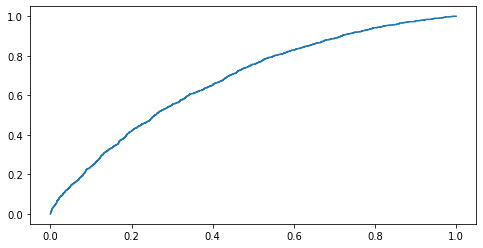

In [67]:
#LightGBMのハイパーパラメータ設定
params = {
    'objective': 'binary', 
    'metric': 'auc',
    'num_leaves': 23,
    'learning_rate': 0.05, 
    'feature_fraction': 0.4, 
    'bagging_fraction': 0.8,
    'bagging_freq': 3,
    'verbose': -1,
    'lambda_l1': 0.81,
    'lambda_l2': 90
}
auc_sum = []
preds = []
splits = 7
kf2 = KFold(n_splits = splits, shuffle = True, random_state = 53)
for fold, (train_idx, valid_idx) in enumerate(kf2.split(Train_x)):
    X_tr, y_tr = Train_x.iloc[train_idx, :], train_y.iloc[train_idx]
    X_val, y_val = Train_x.iloc[valid_idx, :], train_y.iloc[valid_idx]
    
    train_set = lgb.Dataset(X_tr, y_tr)
    val_set = lgb.Dataset(X_val, y_val)
    
    model = lgb.train(params, train_set, num_boost_round = 500, early_stopping_rounds = 100, valid_sets = [train_set, val_set], verbose_eval = 100)
    
    y_pred = model.predict(X_val)
    auc = roc_auc_score(y_val, y_pred)
    pred = model.predict(Test_x)
    preds.append(pred)
    
    print(f'Fold {fold + 1}: AUC = {auc:4f}')
    auc_sum.append(auc)

#特徴量の重要度を出力する
importances = model.feature_importance()
column_names = Train_x.columns.values
temp = []
for i in range(len(column_names)):
    temp.append([importances[i],column_names[i]])
temp.sort(reverse=True, key=lambda x:x[0])
for i in range(len(temp)):
    print(temp[i][0]," : ",temp[i][1])
    
print(np.mean(auc_sum))

last_pred_1 = len(test_y) * [0.0]
for i in range(len(test_y)):
    for j in range(splits):
        last_pred_1[i] += preds[j][i]
    last_pred_1[i] /= splits


curve = roc_curve(test_y, last_pred_1)
plt.plot(curve[0], curve[1])
auc_test = roc_auc_score(test_y, last_pred_1)
print(auc_test)
ensemble_preds = []
ensemble_preds.append(last_pred_1)

## ②LogisticRegression(アンサンブルで0倍が最適のため不採用)

Fold 1: AUC = 0.6243
Fold 2: AUC = 0.6481
Fold 3: AUC = 0.6368
Fold 4: AUC = 0.6198
Fold 5: AUC = 0.6139
Fold 6: AUC = 0.6545
Fold 7: AUC = 0.6312
0.6326706168189113
0.6492732671847292


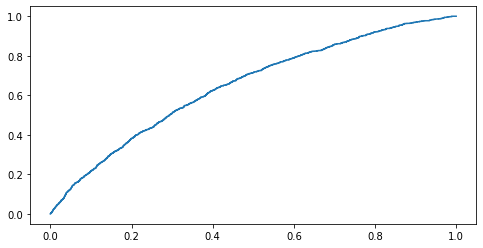

In [68]:
auc_sum = []
preds = []
splits = 7
kf2 = KFold(n_splits = splits, shuffle = True, random_state = 53)
for fold, (train_idx, valid_idx) in enumerate(kf2.split(Train_x)):
    X_tr, y_tr = Train_x.iloc[train_idx, :], train_y.iloc[train_idx]
    X_val, y_val = Train_x.iloc[valid_idx, :], train_y.iloc[valid_idx]
    
    model = LogisticRegression(penalty = 'none',
                               dual = False,
                               tol = 0.001,
                               C = 1.0,
                               fit_intercept = True,
                               intercept_scaling = 1,
                               class_weight = None,
                               random_state = None,
                               solver = 'saga',
                               max_iter = 100,
                               multi_class = 'auto',
                               verbose = 0,
                               warm_start = False,
                               n_jobs = None,
                               l1_ratio = None
                              )
    #訓練データをモデルに適合させる
    model.fit(X_tr, y_tr)
    
    #訓練データから予測 & aucの算出
    y_pred_2d = model.predict_proba(X_val)
    y_pred = y_pred_2d[:,1]
    auc = roc_auc_score(y_val, y_pred)
    
    pred_2d = model.predict_proba(Test_x)
    pred = pred_2d[:,1]
    preds.append(pred)
    test_size = len(pred)
    
    print(f'Fold {fold + 1}: AUC = {auc:.4f}')
    auc_sum.append(auc)

print(np.mean(auc_sum))

last_pred_2 = len(test_y) * [0.0]
for i in range(len(test_y)):
    for j in range(splits):
        last_pred_2[i] += preds[j][i]
    last_pred_2[i] /= splits


curve = roc_curve(test_y, last_pred_2)
plt.plot(curve[0], curve[1])
auc_test = roc_auc_score(test_y, last_pred_2)
print(auc_test)

## ③SGDClassifier(アンサンブルで0倍が最適のため不採用)

Fold 1: AUC = 0.6463
Fold 2: AUC = 0.6347
Fold 3: AUC = 0.6362
Fold 4: AUC = 0.6343
Fold 5: AUC = 0.6671
Fold 6: AUC = 0.5999
Fold 7: AUC = 0.6458
0.6377362432653177
0.6539000567174298


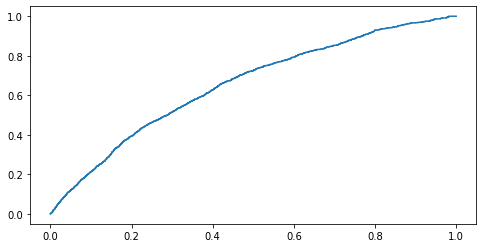

In [69]:
auc_sum = []
preds = []
splits = 7
kf2 = KFold(n_splits=splits,shuffle=True,random_state=71)

for fold, (train_idx, valid_idx) in enumerate(kf2.split(Train_x)):
    X_tr, y_tr = Train_x.iloc[train_idx, :], train_y.iloc[train_idx]
    X_val,y_val = Train_x.iloc[valid_idx, :], train_y.iloc[valid_idx]
    
    #ロジスティック回帰のインスタンスを生成
    lr = SGDClassifier(penalty='elasticnet',
                       alpha = 0.003,
                       l1_ratio = 0.3,
                       tol=0.0001,
                       fit_intercept=True,
                       class_weight='balanced',
                       random_state=None,
                       max_iter=1000,
                       verbose=0,
                       warm_start=False,
                       n_jobs=None,
                       loss ='log_loss'
                       )
    #訓練データをモデルに適合させる
    lr.fit(X_tr,y_tr)
    
    #訓練データから予測 & aucの算出
    y_pred_2d = lr.predict_proba(X_val)
    y_pred = y_pred_2d[:,1]
    auc = roc_auc_score(y_val, y_pred)
    
    pred_2d = lr.predict_proba(Test_x)
    pred = pred_2d[:,1]
    preds.append(pred)
    test_size = len(pred)
    
    print(f'Fold {fold + 1}: AUC = {auc:.4f}')
    auc_sum.append(auc)

print(np.mean(auc_sum))

last_pred_3 = len(test_y) * [0.0]
for i in range(len(test_y)):
    for j in range(splits):
        last_pred_3[i] += preds[j][i]
    last_pred_3[i] /= splits


curve = roc_curve(test_y, last_pred_3)
plt.plot(curve[0], curve[1])
auc_test = roc_auc_score(test_y, last_pred_3)
print(auc_test)

## ④SVM(処理に時間がかかりすぎたため不採用)

In [70]:
'''
from sklearn.pipeline import Pipeline

auc_sum = []
preds = []
splits = 7
kf2 = KFold(n_splits = splits, shuffle = True, random_state = 53)
for fold, (train_idx, valid_idx) in enumerate(kf2.split(train_x)):
    X_tr, y_tr = Train_x.iloc[train_idx, :], train_y.iloc[train_idx]
    X_val, y_val = Train_x.iloc[valid_idx, :], train_y.iloc[valid_idx]
    
    clf = svm.SVC(kernel = 'linear', probability = True)
    
    #訓練データをモデルに適合させる
    clf.fit(X_tr,y_tr)
    
    #訓練データから予測 & aucの算出
    y_pred_2d = clf.predict(X_val, prediction_type='Probability')
    y_pred = y_pred_2d[:,1]
    auc = roc_auc_score(y_val, y_pred)
    
    pred_2d = clf.predict(Test_x, prediction_type='Probability')
    pred = pred_2d[:,1]
    preds.append(pred)
    test_size = len(pred)
    
    print(f'Fold {fold + 1}: AUC = {auc:.4f}')
    auc_sum.append(auc)

print(np.mean(auc_sum))

last_pred_4 = len(test_y) * [0.0]
for i in range(len(test_y)):
    for j in range(splits):
        last_pred_4[i] += preds[j][i]
    last_pred_4[i] /= splits


curve = roc_curve(test_y, last_pred_4)
plt.plot(curve[0], curve[1])
auc_test = roc_auc_score(test_y, last_pred_4)
print(auc_test)
'''

pass

## ⑤決定木(他に比べて明らかにスコアが低いので不採用)

Fold 1: AUC = 0.5371
Fold 2: AUC = 0.5297
Fold 3: AUC = 0.5471
Fold 4: AUC = 0.5170
Fold 5: AUC = 0.5390
Fold 6: AUC = 0.5244
Fold 7: AUC = 0.5091
0.5290503259333018
0.6187751398378012


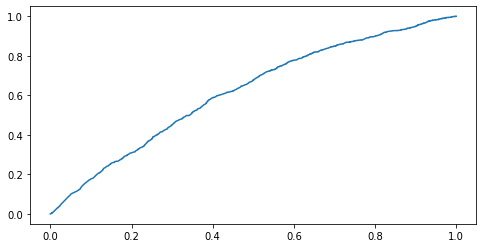

In [71]:
from sklearn import tree

auc_sum = []
preds = []
splits = 7
kf2 = KFold(n_splits = splits, shuffle = True, random_state = 53)
for fold, (train_idx, valid_idx) in enumerate(kf2.split(Train_x)):
    X_tr, y_tr = Train_x.iloc[train_idx, :], train_y.iloc[train_idx]
    X_val, y_val = Train_x.iloc[valid_idx, :], train_y.iloc[valid_idx]
    
    clf = tree.DecisionTreeClassifier(criterion = 'gini',
                                      splitter = 'best',
                                      max_depth = 4, 
                                      min_samples_split = 3,
                                      min_samples_leaf = 1,
                                      min_weight_fraction_leaf = 0.0,
                                      max_features = 4,
                                      random_state = None,
                                      max_leaf_nodes = 8,
                                      min_impurity_decrease = 1e-07,
                                      class_weight = 'balanced'
                                     )
    #訓練データをモデルに適合させる
    clf.fit(X_tr,y_tr)
    
    #訓練データから予測 & aucの算出
    y_pred_2d = clf.predict_proba(X_val)
    y_pred = y_pred_2d[:,1]
    auc = roc_auc_score(y_val, y_pred)
    
    pred_2d = clf.predict_proba(Test_x)
    pred = pred_2d[:,1]
    preds.append(pred)
    test_size = len(pred)
    
    print(f'Fold {fold + 1}: AUC = {auc:.4f}')
    auc_sum.append(auc)

print(np.mean(auc_sum))

last_pred_5 = len(test_y) * [0.0]
for i in range(len(test_y)):
    for j in range(splits):
        last_pred_5[i] += preds[j][i]
    last_pred_5[i] /= splits


curve = roc_curve(test_y, last_pred_5)
plt.plot(curve[0], curve[1])
auc_test = roc_auc_score(test_y, last_pred_5)
print(auc_test)

## ⑥ランダムフォレスト

Fold 1: AUC = 0.6245
Fold 2: AUC = 0.6420
Fold 3: AUC = 0.6333
Fold 4: AUC = 0.6054
Fold 5: AUC = 0.6260
Fold 6: AUC = 0.6245
Fold 7: AUC = 0.6094
0.6235937448289313
0.6525735126342964


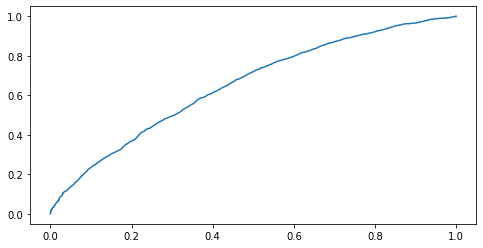

In [72]:
auc_sum = []
preds = []
splits = 7
kf2 = KFold(n_splits = splits, shuffle = True, random_state = 53)
for fold, (train_idx, valid_idx) in enumerate(kf2.split(Train_x)):
    X_tr, y_tr = Train_x.iloc[train_idx, :], train_y.iloc[train_idx]
    X_val, y_val = Train_x.iloc[valid_idx, :], train_y.iloc[valid_idx]
    
    clf = RandomForestClassifier(random_state = 53)
    #訓練データをモデルに適合させる
    clf.fit(X_tr,y_tr)
    
    #訓練データから予測 & aucの算出
    y_pred_2d = clf.predict_proba(X_val)
    y_pred = y_pred_2d[:,1]
    auc = roc_auc_score(y_val, y_pred)
    
    pred_2d = clf.predict_proba(Test_x)
    pred = pred_2d[:,1]
    preds.append(pred)
    test_size = len(pred)
    
    print(f'Fold {fold + 1}: AUC = {auc:.4f}')
    auc_sum.append(auc)

print(np.mean(auc_sum))

last_pred_6 = len(test_y) * [0.0]
for i in range(len(test_y)):
    for j in range(splits):
        last_pred_6[i] += preds[j][i]
    last_pred_6[i] /= splits


curve = roc_curve(test_y, last_pred_6)
plt.plot(curve[0], curve[1])
auc_test = roc_auc_score(test_y, last_pred_6)
print(auc_test)
ensemble_preds.append(last_pred_6)

# ⑦アダブースト

Fold 1: AUC = 0.6318
Fold 2: AUC = 0.6305
Fold 3: AUC = 0.6277
Fold 4: AUC = 0.6182
Fold 5: AUC = 0.6283
Fold 6: AUC = 0.6323
Fold 7: AUC = 0.6433
0.6302922304418443
0.649605178236153


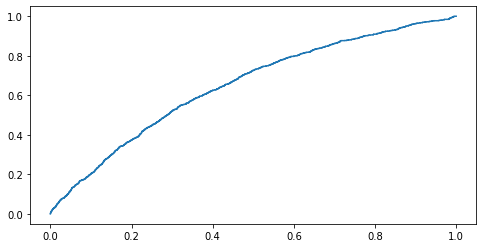

In [73]:
auc_sum = []
preds = []
splits = 7
kf2 = KFold(n_splits = splits, shuffle = True, random_state = 53)
for fold, (train_idx, valid_idx) in enumerate(kf2.split(Train_x)):
    X_tr, y_tr = Train_x.iloc[train_idx, :], train_y.iloc[train_idx]
    X_val, y_val = Train_x.iloc[valid_idx, :], train_y.iloc[valid_idx]
    
    clf = AdaBoostClassifier(random_state = 53)
    #訓練データをモデルに適合させる
    clf.fit(X_tr,y_tr)
    
    #訓練データから予測 & aucの算出
    y_pred_2d = clf.predict_proba(X_val)
    y_pred = y_pred_2d[:,1]
    auc = roc_auc_score(y_val, y_pred)
    
    pred_2d = clf.predict_proba(Test_x)
    pred = pred_2d[:,1]
    preds.append(pred)
    test_size = len(pred)
    
    print(f'Fold {fold + 1}: AUC = {auc:.4f}')
    auc_sum.append(auc)

print(np.mean(auc_sum))

last_pred_7 = len(test_y) * [0.0]
for i in range(len(test_y)):
    for j in range(splits):
        last_pred_7[i] += preds[j][i]
    last_pred_7[i] /= splits


curve = roc_curve(test_y, last_pred_7)
plt.plot(curve[0], curve[1])
auc_test = roc_auc_score(test_y, last_pred_7)
print(auc_test)
ensemble_preds.append(last_pred_7)

## ⑧catboost

0:	learn: 0.5814157	test: 0.5805625	best: 0.5805625 (0)	total: 5.9ms	remaining: 1.17s
1:	learn: 0.5045485	test: 0.5026669	best: 0.5026669 (1)	total: 13.6ms	remaining: 1.35s
2:	learn: 0.4547336	test: 0.4522333	best: 0.4522333 (2)	total: 20.6ms	remaining: 1.35s
3:	learn: 0.4205583	test: 0.4179391	best: 0.4179391 (3)	total: 28.1ms	remaining: 1.38s
4:	learn: 0.3988720	test: 0.3962179	best: 0.3962179 (4)	total: 36.3ms	remaining: 1.41s
5:	learn: 0.3830285	test: 0.3804836	best: 0.3804836 (5)	total: 43.3ms	remaining: 1.4s
6:	learn: 0.3728174	test: 0.3705045	best: 0.3705045 (6)	total: 50.6ms	remaining: 1.39s
7:	learn: 0.3650516	test: 0.3629086	best: 0.3629086 (7)	total: 56.4ms	remaining: 1.35s
8:	learn: 0.3589935	test: 0.3577303	best: 0.3577303 (8)	total: 62.6ms	remaining: 1.33s
9:	learn: 0.3543860	test: 0.3538983	best: 0.3538983 (9)	total: 68.2ms	remaining: 1.29s
10:	learn: 0.3522163	test: 0.3517085	best: 0.3517085 (10)	total: 73.6ms	remaining: 1.26s
11:	learn: 0.3498293	test: 0.3499532	best: 

71:	learn: 0.2962774	test: 0.3526999	best: 0.3519672 (64)	total: 372ms	remaining: 661ms
72:	learn: 0.2955755	test: 0.3525707	best: 0.3519672 (64)	total: 377ms	remaining: 656ms
73:	learn: 0.2945315	test: 0.3526274	best: 0.3519672 (64)	total: 382ms	remaining: 651ms
74:	learn: 0.2939682	test: 0.3526915	best: 0.3519672 (64)	total: 387ms	remaining: 645ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.3519672104
bestIteration = 64

Shrink model to first 65 iterations.
Fold 2: AUC = 0.6780
0:	learn: 0.5773625	test: 0.5817213	best: 0.5817213 (0)	total: 5.99ms	remaining: 1.19s
1:	learn: 0.5016816	test: 0.5090685	best: 0.5090685 (1)	total: 11ms	remaining: 1.09s
2:	learn: 0.4519438	test: 0.4619417	best: 0.4619417 (2)	total: 16.4ms	remaining: 1.08s
3:	learn: 0.4166463	test: 0.4299330	best: 0.4299330 (3)	total: 22ms	remaining: 1.08s
4:	learn: 0.3942526	test: 0.4096988	best: 0.4096988 (4)	total: 27.1ms	remaining: 1.06s
5:	learn: 0.3786876	test: 0.3959767	best: 0.3959767 (5)	tota

38:	learn: 0.3233474	test: 0.3144646	best: 0.3144646 (38)	total: 220ms	remaining: 909ms
39:	learn: 0.3225054	test: 0.3143702	best: 0.3143702 (39)	total: 225ms	remaining: 901ms
40:	learn: 0.3217711	test: 0.3142947	best: 0.3142947 (40)	total: 230ms	remaining: 892ms
41:	learn: 0.3212597	test: 0.3139597	best: 0.3139597 (41)	total: 235ms	remaining: 884ms
42:	learn: 0.3206606	test: 0.3139581	best: 0.3139581 (42)	total: 240ms	remaining: 877ms
43:	learn: 0.3199952	test: 0.3137693	best: 0.3137693 (43)	total: 245ms	remaining: 869ms
44:	learn: 0.3196131	test: 0.3137782	best: 0.3137693 (43)	total: 251ms	remaining: 863ms
45:	learn: 0.3187845	test: 0.3138232	best: 0.3137693 (43)	total: 256ms	remaining: 857ms
46:	learn: 0.3180313	test: 0.3138367	best: 0.3137693 (43)	total: 261ms	remaining: 851ms
47:	learn: 0.3175121	test: 0.3138399	best: 0.3137693 (43)	total: 266ms	remaining: 844ms
48:	learn: 0.3166203	test: 0.3141668	best: 0.3137693 (43)	total: 271ms	remaining: 835ms
49:	learn: 0.3158408	test: 0.314

32:	learn: 0.3252038	test: 0.3254605	best: 0.3254605 (32)	total: 182ms	remaining: 923ms
33:	learn: 0.3241719	test: 0.3251360	best: 0.3251360 (33)	total: 187ms	remaining: 914ms
34:	learn: 0.3236516	test: 0.3251749	best: 0.3251360 (33)	total: 192ms	remaining: 904ms
35:	learn: 0.3228259	test: 0.3249124	best: 0.3249124 (35)	total: 197ms	remaining: 897ms
36:	learn: 0.3218548	test: 0.3248576	best: 0.3248576 (36)	total: 202ms	remaining: 892ms
37:	learn: 0.3210902	test: 0.3244764	best: 0.3244764 (37)	total: 208ms	remaining: 886ms
38:	learn: 0.3206648	test: 0.3243346	best: 0.3243346 (38)	total: 213ms	remaining: 880ms
39:	learn: 0.3203104	test: 0.3244342	best: 0.3243346 (38)	total: 218ms	remaining: 872ms
40:	learn: 0.3195487	test: 0.3243993	best: 0.3243346 (38)	total: 223ms	remaining: 864ms
41:	learn: 0.3189199	test: 0.3246234	best: 0.3243346 (38)	total: 228ms	remaining: 858ms
42:	learn: 0.3183055	test: 0.3246475	best: 0.3243346 (38)	total: 233ms	remaining: 851ms
43:	learn: 0.3174047	test: 0.324

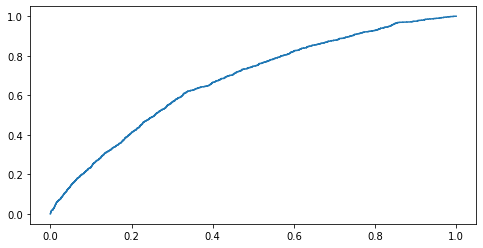

In [77]:
auc_sum = []
preds = []
splits = 7
kf2 = KFold(n_splits = splits, shuffle = True, random_state = 74)
for fold, (train_idx, valid_idx) in enumerate(kf2.split(Train_x)):
    X_tr, y_tr = Train_x.iloc[train_idx, :], train_y.iloc[train_idx]
    X_val, y_val = Train_x.iloc[valid_idx, :], train_y.iloc[valid_idx]
    
    train_pool = Pool(X_tr, label = y_tr)
    test_pool  = Pool(X_val,label = y_val)
    
    params = {
        'depth' : 6,
        'learning_rate' : 0.16,
        'early_stopping_rounds' : 10,
        'iterations' : 200,
        'custom_loss' : ['Accuracy'],
        'random_seed' : 42,   
    }

    clf = CatBoostClassifier(**params)
    #訓練データをモデルに適合させる
    clf.fit(train_pool, eval_set = test_pool)
    
    #訓練データから予測 & aucの算出
    y_pred_2d = clf.predict(X_val, prediction_type='Probability')
    y_pred = y_pred_2d[:,1]
    auc = roc_auc_score(y_val, y_pred)
    
    pred_2d = clf.predict(Test_x, prediction_type='Probability')
    pred = pred_2d[:,1]
    preds.append(pred)
    test_size = len(pred)
    
    print(f'Fold {fold + 1}: AUC = {auc:.4f}')
    auc_sum.append(auc)

print(np.mean(auc_sum))

last_pred_8 = len(test_y) * [0.0]
for i in range(len(test_y)):
    for j in range(splits):
        last_pred_8[i] += preds[j][i]
    last_pred_8[i] /= splits


curve = roc_curve(test_y, last_pred_8)
plt.plot(curve[0], curve[1])
auc_test = roc_auc_score(test_y, last_pred_8)
print(auc_test)
ensemble_preds.append(last_pred_8)

# 最終スコアの算出

## アンサンブル

In [75]:
from itertools import product

def find_permutations(n):
    perm_list = []
    current_perm = [0] * n
    
    while True:
        if sum(current_perm) == 10:
            perm_list.append(tuple(current_perm))
    
        i = n-1
        while i >= 0 and current_perm[i] == 10:
            current_perm[i] = 0
            i -= 1
            
        if i < 0:
            break
        
        current_perm[i] += 1
    
    return perm_list

n = 4
permutations = find_permutations(n)
last_pred = len(test_y) * [0.0]
l = []
for i in range(n):
    l.append(0.0)
best_score = 0
for perm in permutations:
    for i in range(len(test_y)):
        last_pred_list = len(test_y) * l
        last_pred_list[i] = [last_pred_1[i], last_pred_6[i], last_pred_7[i], last_pred_8[i]]
        last_pred[i] = np.dot(last_pred_list[i], perm) / 10
    auc_test = roc_auc_score(test_y, last_pred)
    if auc_test > best_score:
        best_score = auc_test
        best_perm = perm
    print(perm, auc_test)
print('best param is ', best_perm, ', best score is ', best_score)

(0, 0, 0, 10) 0.6781346158860958
(0, 0, 1, 9) 0.6781434168665901
(0, 0, 2, 8) 0.6781298894336081
(0, 0, 3, 7) 0.6780767575884009
(0, 0, 4, 6) 0.677932111844164
(0, 0, 5, 5) 0.677687966126004


KeyboardInterrupt: 

In [76]:
def max_score(preds,dif,test_y,over_value_sum = [0.0], depth = [0],max = [0.0], ensemble_pred = [0.0],max_ratio = [0.0], now_ratio = [0.0]):
    
    if len(preds) == depth[0]+1: #最深部での処理
        temp_ensemble_pred = len(preds[0])*[0.0]
        
        for i in range(len(preds[0])):
            temp_ensemble_pred[i] = ensemble_pred[i]
            
        value = 1.0 - over_value_sum[0]
        now_ratio[depth[0]] = value
        
        for i in range(len(preds[0])):
            ensemble_pred[i] += preds[depth[0]][i]*value
        ensemble_auc = roc_auc_score(test_y,ensemble_pred)
        
        for i in range(len(preds[0])):
            ensemble_pred[i] = temp_ensemble_pred[i]
            
        if ensemble_auc > max[0]:
            for i in range(len(now_ratio)):
                max_ratio[i] = now_ratio[i]
            max[0] = ensemble_auc
        
        
    elif depth[0] == 0:              #最浅部での処理
        ensemble_pred = len(preds[0])*[0.0] #最深部でAUCを計算するためのリスト
        max_ratio  = len(preds)*[0.0]       #AUCの最大値を更新した際に、それを与えたアンサンブル割合を格納するリスト
        now_ratio  = len(preds)*[0.0]       #現在のアンサンブル割合を格納するリスト
        while over_value_sum[0]<=1.0+dif:
                
            max_score(preds=preds,dif=dif,test_y=test_y,over_value_sum= over_value_sum,depth = [1], max = max, ensemble_pred = ensemble_pred, max_ratio = max_ratio, now_ratio = now_ratio)
            
            for i in range(len(preds[0])):
                ensemble_pred[i] += preds[depth[0]][i]*dif
                
            now_ratio[depth[0]] += dif
            over_value_sum[0] += dif
            
        return [max[0],max_ratio]
    else:  #その他の深さでの処理
        now_ratio[depth[0]] = 0.0
        temp_ratio = now_ratio
        temp_over_value_sum = over_value_sum[0]
        
        temp_ensemble_pred = len(preds[0])*[0.0]
        for i in range(len(preds[0])):
            temp_ensemble_pred[i] = ensemble_pred[i]
            
        while over_value_sum[0]<=1.0:
                
            max_score(preds=preds,dif=dif,test_y=test_y,over_value_sum = over_value_sum, depth = [depth[0]+1],max = max, ensemble_pred = ensemble_pred, max_ratio = max_ratio, now_ratio = now_ratio)
            
            for i in range(len(preds[0])):
                ensemble_pred[i] += preds[depth[0]][i]*dif
                
            now_ratio[depth[0]] += dif
            over_value_sum[0] += dif
        now_ratio = temp_ratio
        over_value_sum[0] = temp_over_value_sum
        
        for i in range(len(preds[0])):
            ensemble_pred[i] = temp_ensemble_pred[i]
            
        now_ratio[depth[0]] = 0.0
        
#アンサンブル処理
dif = 0.05
result = max_score(preds = ensemble_preds, dif = dif, test_y = test_y)
print(result)

[0.6807228375664963, [0.39999999999999997, 0.1, 0.05, 0.45000000000000007]]
